## Problem Statement
- Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online - -application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.


In [22]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import numpy as np
from numpy import NaN
from statistics import mode
#from imblearn.over_sampling import SMOTE

## Helper Function

In [23]:
#apply label encoding 
def Feature_Encoder(X,cols):
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
    return X


## Reading Data and Checking NaN Values and Duplicates 

In [24]:
df = pd.read_csv('loan_data.csv')
print(df.isnull().sum())
print("Duplicates:        ",df.duplicated().sum())
df.describe()
df

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Duplicates:         0


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


## Spliting Columns based on categorical and numerical

In [25]:
categorical = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Amount_Term', 'Dependents','Loan_Status']
numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

In [26]:
# As number of NaN values are few in comparision to known values in almost all columns thus replacing categroical values with the most frequent value and regresive values with the mean.
for col in numerical:
    df[f'{col}'].replace(NaN, df[f'{col}'].mean(skipna=True), inplace=True)

for col in categorical:
    df[f'{col}'].replace(NaN, df[f'{col}'].mode()[0], inplace=True)

<AxesSubplot:xlabel='Married', ylabel='Count'>

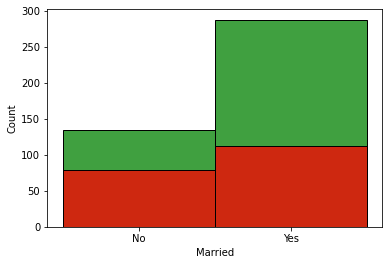

In [27]:
sns.histplot(df[df['Loan_Status'] == "Y"]['Married'], color='green')
sns.histplot(df[df['Loan_Status'] == "N"]['Married'], color='red')

<AxesSubplot:xlabel='Education', ylabel='Count'>

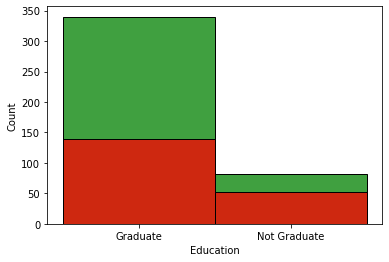

In [28]:
sns.histplot(df[df['Loan_Status'] == "Y"]['Education'], color='green')
sns.histplot(df[df['Loan_Status'] == "N"]['Education'], color='red')

<AxesSubplot:xlabel='Property_Area', ylabel='Count'>

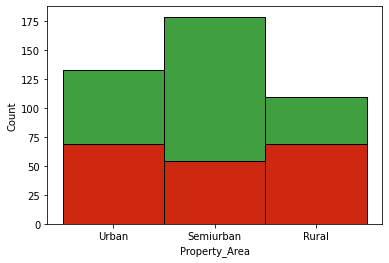

In [29]:
sns.histplot(df[df['Loan_Status'] == "Y"]['Property_Area'], color='green')
sns.histplot(df[df['Loan_Status'] == "N"]['Property_Area'], color='red')

## Encoding Categorical Values

In [30]:
df=Feature_Encoder(df,categorical)
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,146.412162,8,1,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.000000,8,1,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.000000,8,1,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.000000,8,1,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.000000,8,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,0,0,0,0,2900,0.0,71.000000,8,1,0,1
610,LP002979,1,1,3,0,0,4106,0.0,40.000000,5,1,0,1
611,LP002983,1,1,1,0,0,8072,240.0,253.000000,8,1,2,1
612,LP002984,1,1,2,0,0,7583,0.0,187.000000,8,1,2,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    int32  
 2   Married            614 non-null    int32  
 3   Dependents         614 non-null    int32  
 4   Education          614 non-null    int32  
 5   Self_Employed      614 non-null    int32  
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    int64  
 10  Credit_History     614 non-null    int64  
 11  Property_Area      614 non-null    int32  
 12  Loan_Status        614 non-null    int32  
dtypes: float64(2), int32(7), int64(3), object(1)
memory usage: 45.7+ KB


## Checking Outliers

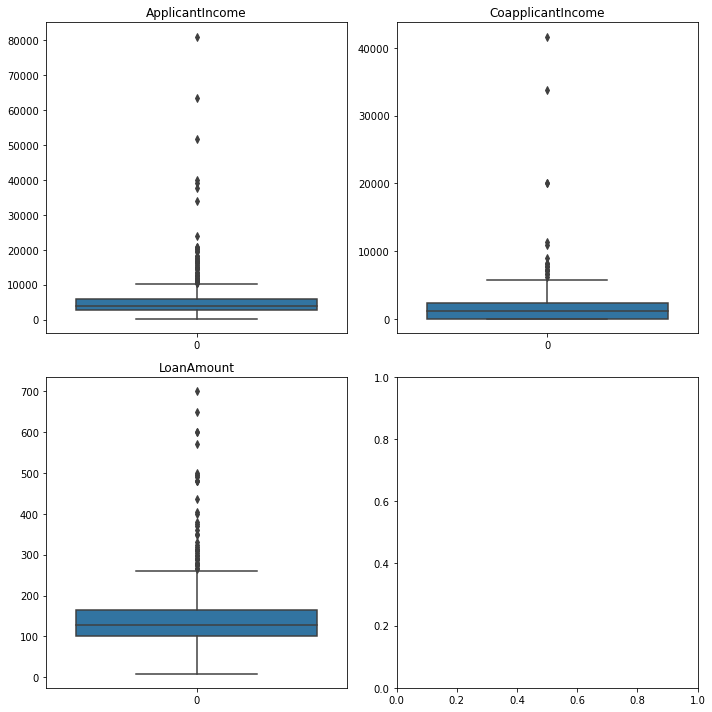

In [32]:
fig, axis = plt.subplots(2, 2, figsize=(10,10))

for id, i in enumerate(numerical):
    sns.boxplot(data=df['{}'.format(i)], ax=axis[id//2, id%2])
    axis[id//2, id%2].set_title(f'{i}')
plt.tight_layout()

## Removing Outliers

In [33]:
Q1 = df[numerical].quantile(0.25)
Q3 = df[numerical].quantile(0.75)
IQR = Q3 - Q1
IQR

ApplicantIncome      2917.50
CoapplicantIncome    2297.25
LoanAmount             64.50
dtype: float64

In [34]:
df[numerical] = df[~((df[numerical] > Q3+1.5*IQR) | (df[numerical] < Q1 - 1.5*IQR))][numerical]
df = df.dropna().reset_index().drop('index', axis=1)
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849.0,0.0,146.412162,8,1,2,1
1,LP001003,1,1,1,0,0,4583.0,1508.0,128.000000,8,1,0,0
2,LP001005,1,1,0,0,1,3000.0,0.0,66.000000,8,1,2,1
3,LP001006,1,1,0,1,0,2583.0,2358.0,120.000000,8,1,2,1
4,LP001008,1,0,0,0,0,6000.0,0.0,141.000000,8,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,LP002978,0,0,0,0,0,2900.0,0.0,71.000000,8,1,0,1
531,LP002979,1,1,3,0,0,4106.0,0.0,40.000000,5,1,0,1
532,LP002983,1,1,1,0,0,8072.0,240.0,253.000000,8,1,2,1
533,LP002984,1,1,2,0,0,7583.0,0.0,187.000000,8,1,2,1


In [35]:
df.corr()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,0.372519,0.187076,0.072320,0.021148,0.074849,0.198652,0.148249,-0.068856,0.005714,-0.006906,0.047217
Married,0.372519,1.000000,0.340098,0.025423,0.016299,0.006116,0.258669,0.203016,-0.069947,0.008181,0.012458,0.085391
Dependents,0.187076,0.340098,1.000000,0.082991,0.054542,0.118185,-0.064006,0.114099,-0.086719,-0.032058,0.016343,0.008150
Education,0.072320,0.025423,0.082991,1.000000,0.000869,-0.147857,-0.028559,-0.117899,-0.074487,-0.085002,-0.063382,-0.114159
Self_Employed,0.021148,0.016299,0.054542,0.000869,1.000000,0.187889,-0.056586,0.087663,-0.055563,0.031554,-0.060971,-0.005302
ApplicantIncome,0.074849,0.006116,0.118185,-0.147857,0.187889,1.000000,-0.266763,0.475531,-0.051219,0.051843,-0.076389,0.013046
CoapplicantIncome,0.198652,0.258669,-0.064006,-0.028559,-0.056586,-0.266763,1.000000,0.287415,-0.006535,0.008528,-0.092128,0.068056
LoanAmount,0.148249,0.203016,0.114099,-0.117899,0.087663,0.475531,0.287415,1.000000,0.090923,0.008066,-0.115322,-0.020474
Loan_Amount_Term,-0.068856,-0.069947,-0.086719,-0.074487,-0.055563,-0.051219,-0.006535,0.090923,1.000000,-0.013797,-0.091764,-0.004415
Credit_History,0.005714,0.008181,-0.032058,-0.085002,0.031554,0.051843,0.008528,0.008066,-0.013797,1.000000,0.009835,0.566580


## Checking Imbalance
- Number of approved Loans are much more than Number of approved Loans

<AxesSubplot:xlabel='Loan_Status', ylabel='Count'>

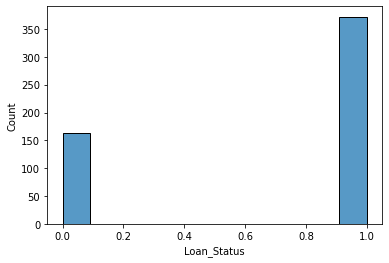

In [36]:
sns.histplot(df['Loan_Status'])

## Splitting into training and testing then using SMOTE to rectify class imbalance

In [37]:
X=df.iloc[:,1:-1]
Y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
#X_train, y_train = SMOTE().fit_resample(X=X_train, y=y_train)

## Using XGBoost and checking the appropriate value of max_depth parameter

In [38]:
precision = []
recall = []
macc = []
f1 = []
for max_depth in range(3, 15):
    XGBclassifier = XGBClassifier(n_estimators = 1000, max_depth = max_depth, learning_rate = 0.03, objective = 'binary:logistic', eval_metric = 'auc')
    XGBclassifier.fit(X_train, y_train)
    xyz = XGBclassifier.predict(X_test)
    precision.append(precision_score(y_test, xyz))
    recall.append(recall_score(y_test, xyz))
    f1.append(f1_score(y_test, xyz))
    macc.append(accuracy_score(y_test, xyz))

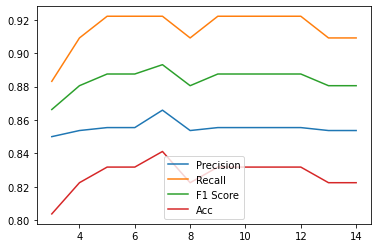

In [39]:
X = np.arange(3, 15)
plt.plot(X[:12], precision[:12], label = 'Precision')
plt.plot(X[:12], recall[:12], label = 'Recall')
plt.plot(X[:12], f1[:12], label = 'F1 Score')
plt.plot(X[:12], macc[:12], label = 'Acc')
plt.legend()

In [40]:
max_depth = mode([3+np.argmax(f1), 3+np.argmax(precision), 3+np.argmax(macc), 3+np.argmax(recall)])
max_depth

7

## Training 7 models over training data

In [41]:
C = 0.001  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
lin_svc = svm.LinearSVC(C=C).fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.8, C=C).fit(X_train, y_train)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X_train, y_train)
AdaBoost = AdaBoostClassifier(n_estimators=1000,learning_rate=0.05)
AdaBoost.fit(X_train,y_train)
xgboost = XGBClassifier(n_estimators = 1000, learning_rate = 0.05,max_depth=7).fit(X_train, y_train, early_stopping_rounds = 5, eval_set = [(X_test, y_test)],verbose = False)
RF = RandomForestClassifier(n_estimators = 1000,max_depth=7, random_state=0)
RF.fit(X_train, y_train)

titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
         'AdaBoost',
         'XGBoost',
          'RF']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc,AdaBoost,xgboost,RF)):
    print(titles[i])
    
    predictions = clf.predict(X_train)
    accuracy = np.mean(predictions == y_train)
    print("Train accuracy: ",accuracy)
    
    predictions = clf.predict(X_test)
    accuracy = np.mean(predictions == y_test)
    print("Test accuracy: ",accuracy)


C:\Users\Hazem\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Hazem\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


SVC with linear kernel
Train accuracy:  0.6892523364485982
Test accuracy:  0.719626168224299
LinearSVC (linear kernel)
Train accuracy:  0.3294392523364486
Test accuracy:  0.2803738317757009
SVC with RBF kernel
Train accuracy:  0.6892523364485982
Test accuracy:  0.719626168224299
SVC with polynomial (degree 3) kernel
Train accuracy:  0.6892523364485982
Test accuracy:  0.719626168224299
AdaBoost
Train accuracy:  0.8364485981308412
Test accuracy:  0.8411214953271028
XGBoost
Train accuracy:  0.9158878504672897
Test accuracy:  0.8598130841121495
RF
Train accuracy:  0.8714953271028038
Test accuracy:  0.8598130841121495


## XGBoost Model Made the Best Results

In [42]:
y_pred = xgboost.predict(X_test)
print(confusion_matrix(y_test, y_pred))
"""Confusion Matrix
TP FP
FN TN
"""
print(f"precision_score: {precision_score(y_test, y_pred)}\nrecall_score: {recall_score(y_test, y_pred)}\nf1_Score: {f1_score(y_test, y_pred)}\naccuracy_score: {accuracy_score(y_test, y_pred)}")

[[18 12]
 [ 3 74]]
precision_score: 0.8604651162790697
recall_score: 0.961038961038961
f1_Score: 0.9079754601226995
accuracy_score: 0.8598130841121495


## Results:
- Precision is 0.86
- Recall is 0.96
- Accuracy is 0.86